In [21]:
import os
import numpy as np
import torch
from ase import io
import matplotlib.pyplot as plt
import tqdm as tqdm

torch.Size([72000, 1, 200])


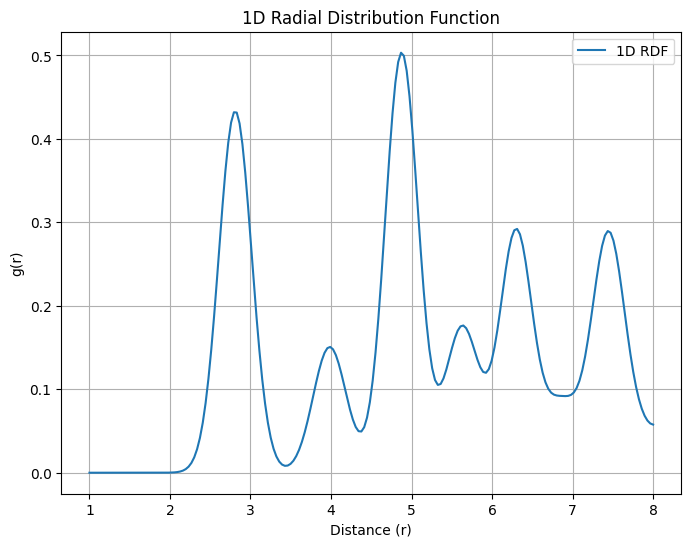

In [2]:
# Load the RDF data from the saved file
rdf_data_path = "./RDFs/rdf_images.pt"  # Replace with the path to your .pt file
rdf_images = torch.load(rdf_data_path)

print(rdf_images.shape)  # Check the shape of the loaded RDF data

# Extract the 1D RDF from the first image (assuming it's 1D)
rdf_1d = rdf_images[0, 0, :].numpy()  # Extracting the first RDF (assuming it's 1D)

# If you need to load the bins corresponding to the RDFs (min_dist, max_dist, and number of bins)
min_dist = 1.0  # You need to specify the same values used during RDF computation
max_dist = 8.0
n_bins = 200
bins = torch.linspace(min_dist, max_dist, n_bins).numpy()

# Plotting the 1D RDF
plt.figure(figsize=(8, 6))
plt.plot(bins, rdf_1d, label="1D RDF")
plt.xlabel("Distance (r)")
plt.ylabel("g(r)")
plt.title("1D Radial Distribution Function")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
from PyISV.network_classification import Classifier  # Your model class

# Define the path to your saved model
model_path = "/scratch/rasera/PyISV/models/classifier_best.pt"

# Initialize your model with the same architecture as during training
model = Classifier(
    input_shape=(1, 200),  # Must match training shape
    embed_dim=32,          # Same as training
    num_classes=7,          # Same as training
    num_encoder_final_channels=8  # Same as training
)

# Load the saved state dict
checkpoint = torch.load(model_path, map_location='cpu')  # Use 'cuda' if using GPU
num_classes = checkpoint['model_state_dict']['fc2.weight'].shape[0]
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set to evaluation mode

Classifier(
  (encoder): Sequential(
    (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=408, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=7, bias=True)
)

In [6]:
def predict_batch(model, data, batch_size=256):
    """Make predictions in batches to avoid memory issues"""
    predictions = []
    probabilities = []
    
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            outputs = model(batch)
            probs = torch.softmax(outputs, dim=1)
            
            predictions.extend(torch.argmax(probs, dim=1).tolist())
            probabilities.extend(probs.numpy())
    
    return predictions, torch.tensor(probabilities)

In [7]:
# Get predictions for all data
class_indices, class_probs = predict_batch(model, rdf_images)

# If you have class names from training
class_names = [0, 1, 2, 3, 4, 5, 6]  # Replace with your actual class names

# Print results for first 5 samples
for i in range(5):
    print(f"Sample {i}:")
    print(f"  Predicted class: {class_names[class_indices[i]]}")
    print("  Class probabilities:")
    for name, prob in zip(class_names, class_probs[i]):
        print(f"    {name}: {prob:.4f}")
    print()

Sample 0:
  Predicted class: 0
  Class probabilities:
    0: 1.0000
    1: 0.0000
    2: 0.0000
    3: 0.0000
    4: 0.0000
    5: 0.0000
    6: 0.0000

Sample 1:
  Predicted class: 6
  Class probabilities:
    0: 0.0000
    1: 0.0000
    2: 0.0004
    3: 0.0000
    4: 0.0686
    5: 0.0425
    6: 0.8884

Sample 2:
  Predicted class: 6
  Class probabilities:
    0: 0.0000
    1: 0.0000
    2: 0.0069
    3: 0.0000
    4: 0.0011
    5: 0.2090
    6: 0.7829

Sample 3:
  Predicted class: 6
  Class probabilities:
    0: 0.0000
    1: 0.0000
    2: 0.0012
    3: 0.0000
    4: 0.0009
    5: 0.1725
    6: 0.8254

Sample 4:
  Predicted class: 6
  Class probabilities:
    0: 0.0000
    1: 0.0000
    2: 0.0000
    3: 0.0000
    4: 0.0003
    5: 0.0068
    6: 0.9929



/tmp/ipykernel_1776524/1973287827.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return predictions, torch.tensor(probabilities)


In [8]:
# Save full predictions
torch.save({
    'indices': class_indices,
    'probabilities': class_probs
}, "./predictions.pt")

# Or save as CSV
import pandas as pd
df = pd.DataFrame({
    'predicted_class': [class_names[i] for i in class_indices],
    **{name: class_probs[:, i] for i, name in enumerate(class_names)}
})
df.to_csv("./predictions.csv", index=False)

Text(0.5, 1.0, 'Histogram of Predicted and True Classes')

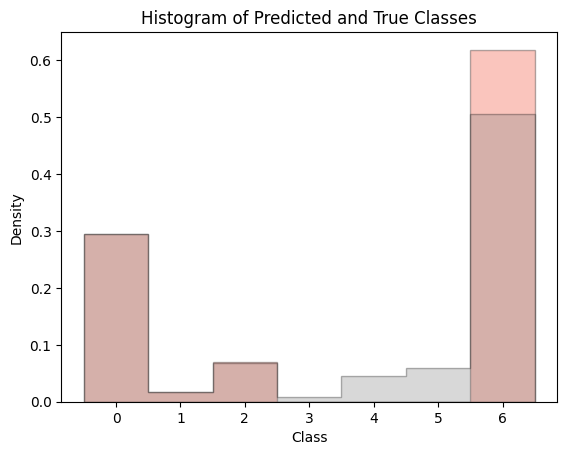

In [28]:
df_true = pd.read_csv("./Ag38_labels/combined_isv_labels_2D_nonMin_to_min_k15_nCu_0.txt", header=None, names=['true_class'])

x1 = df['predicted_class']
x2 = df_true['true_class']

# Create histogram of both predicted and true classes
fig, ax = plt.subplots(1, 1)
ax.hist(x1, bins=np.arange(0, 8) - 0.5, alpha=0.3, label='Predicted', ls='-', color='xkcd:tomato', edgecolor='black', density=True, histtype='stepfilled')
ax.hist(x2, bins=np.arange(0, 8) - 0.5, alpha=0.3, label='True', ls='--', color='gray', density=True, edgecolor='black', histtype='stepfilled')
ax.set_xlabel('Class')
ax.set_ylabel('Density')
ax.set_title('Histogram of Predicted and True Classes')


# How would you improve the model?